<a href="https://colab.research.google.com/github/drpOpZ/WebCrawler/blob/master/Webcrawler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A polite, multi-threaded Python Web Crawler
Final project for the *Information Retrieval* AY 2020/21 course @ University of Trieste.  
Author: **Michele Rispoli**

---

In this notebook we'll present an implementation of a simple web crawler with the following features:

- **Thread-safe, JSON serializable stores**:
  - **Custom visited pages store**, featuring basic network graph plotting;
  - **URL frontier**, allowing URL prioritization (*NOTE: proper prioritizer not included*) and orchestration of requests' timing to enforce politeness;
  - **robots.txt store**, including a basic robots.txt parser and a simple querying interface to respect domain specific crawling restrictions;
- **Multi-thread ready Web crawler**, fitting together all the other components to carry on network exploration safely and politely, also allowing for crawling to be stopped and resumed in separate sessions.

This project was made for academic/educational purposes, therefore performance was not the main concern throughout its realization. Feel free to read, distribute, use (at your own risk!) and modify it however you like :).

---

## What is a web crawler?

Simply put, a **web crawler** (aka *spider*) is a program that explores a network of interlinked hyper-text documents (like the Internet) to **build a map** of its contents.  
Typical uses of the resulting map are:
- searching for specific pieces information within the indexed contents (e.g. through a querying interface)
- analyzing the very structure of the explored network (e.g. identify groups of highly interconnected documents).

Just like real world exploration, the basic scheme of the crawling process consists in repeatedly performing the following operations:
1. Picking a destination (i.e. choosing an URL);
2. Visiting the chosen location and determining where one can go from there (i.e. fetching the page content and retrieving the hyper-links to other web pages cointained in it);
3. Recording the findings and annotating the new locations to visit (i.e. storing the results in the visited page store and the novel URLs in the URL frontier).

### Gather your party
Why venturing alone through the uncharted lands of the internet when we can set an entire party of crawler threads up for the task?  
Implementing a **multi-threaded** architecture requires some extra attention during the design phase, but having multiple workers will speed up the mapping process as multiple domains will be explored at the same time.  
Furthermore, this will also increase the robustness of our approach, as crawling will not be compromised if one or two of our brave explorers get stuck or perish.  
Enough said, let's pack our bags with all the required python modules and sail for the adventure!

In [ ]:
!pip install pycurl

In [ ]:
import pycurl
from io import BytesIO

import threading as th

import re

import datetime
import dateutil.parser as dtp
import time             # ... to sleep()

import json

import queue
import heapdict

import random

# for plotting
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Simple method for shortening string representation of data structures
# used in pretty_print methods
def shorten_rec(o,max_len = 10,max_str_len=100):
  if isinstance(o,list):
    if len(o)==0:
      return o
    elif len(o)<max_len:
      return [shorten_rec(el,max_len,max_str_len) for el in o]
    return  [shorten_rec(el,max_len,max_str_len) for el in o[:max_len]]+ [" ... {} more".format(len(o)-max_len)]
  elif isinstance(o,dict):
    if len(o)==0:
      return o
    return {k:shorten_rec(v,max_len,max_str_len) for k,v in o.items()}
  elif isinstance(o,str):
    return o if len(o)<max_str_len else o[:max_str_len] +" ..."
  return o

## Sailing for.. where? Wait, what's "where"?
Resources on the internet are identified by **URL**s ( **U**niform **R**esource **L**ocators) which follow a [precise syntax](https://www.w3.org/Addressing/URL/url-spec.txt).  
Multiple URLs may point to the same resource. We can broadly distinguish them in two types:
- **Absolute URL**: one that explicitly specifies a *scheme*, an *authority* and a *path*; It's the closest we can get to an unique identifier (although the path bit may allow for some play);
- **Incomplete URL**: one that omits the *authority*, which can generally be deduced from the page where the URL is found.

We'll leverage the arcane power of *RegEx* to recognise valid URLs and keep only the parts that we care for into instances of a simple `NormalizedUrl` class designed for this purpose.

(NOTE: we'll refer to *scheme* + *authorithy* as *domain*. Although tecnically incorrect, this simplifies a bit the mapping process)


### Query-string: It's a TRAP!

URLs may come with *query-string parameters*, that allow dynamic pages to behave differently basing on their values. We may have chosen to teach our crawler how to interpret them, although that adds further complications to the mapping process and may expose our crawler to *perilous traps*, as [this apparently inoffensive online calendar](https://www.timeanddate.com/calendar/): were an unsavvy crawler thread to reach it, it'd be crawling its pages 'till the last day of eternity and over.  
We'll take the simple route and just **trim QS parameters** whenever we encounter them. If somebody asks, you didn't see anything.

In [ ]:
# "... the writing on the ancient tome looked like this:"
re_pat_url = r"^((?:([^:/?#]*):)?(?:\/\/((?:([^:/?#]*)(?::([^@]+))?@)?([^:/?#]*)(?::(\d*))?))?)?((?:[^/?#]*)(?:\/[^/?#]*)*)?(?:\?([^#]*))?(?:#(.*))?$"
# "which, in human language, could be interpreted as"
# [scheme:][//[user[:pw]@]host[:port]][path][?qs][#fragm]
#    2          4    5     6     7      8     9     10
#             ^^^^^^^^^^auth^^^^^^^^^^
#                        3
# ^^^^^^^^^^^^^^^domain^^^^^^^^^^^^^^^
#                  1
def parse_url(url):
  assert(isinstance(url,str))
  return re.match(re_pat_url, url).groups()

# !!! It doesn't infer scheme or path!
class NormalizedUrl():
  def __init__(self, domain=None, path=None, from_str=None):
    if from_str is not None:
      self.domain,_,_,_,_,_,_,self.path,_,_ = parse_url(from_str)
    else:
      assert(domain is not None and path is not None)
      self.domain = domain
      self.path = path
      
  def __str__(self):
    return self.domain + self.path
  
  # used by set
  def __hash__(self):
    return hash(self.__str__())

## Going places, fetching pages
Visiting a web page really means sending an **HTTP (or HTTPS) request** to a server and then displaying the response content... if there is any!  
We're only interested in browsing **web pages**, that is, retrieving response contents of **text type**.  
Our crawler will be sending requests and receiving responses using the `pycurl` package.  
Each response always come with a **header** which cointains useful meta-data about the resource we're requesting.  
The `RespInfo` class defined in the following will process the `curl` objects produced by the `pycurl` module to extract information that is useful for our purposes from the response headers.

In [ ]:
class RespInfo():
  def __init__(self, curl_obj):
    self.update(curl_obj)

  def update(self,curl_obj):
    self.eff_url      = curl_obj.getinfo(pycurl.EFFECTIVE_URL)
    self.datetime     = datetime.datetime.now()
    self.resp_code    = curl_obj.getinfo(pycurl.RESPONSE_CODE)
    self.total_usecs  = curl_obj.getinfo(pycurl.TOTAL_TIME)
    self.content_type = None
    try:
      self.content_type = curl_obj.getinfo(pycurl.CONTENT_TYPE)
    except:
      pass
    self.location = None
    try:
      self.location = curl_obj.getinfo(pycurl.REDIRECT_URL)
    except:
      pass
    self._deduce_charset()

  def _deduce_charset(self):
    self.charset = None
    if self.content_type is not None and \
           re.match("text",self.content_type) is not None:
      m = re.search("charset=([^; ]+)",self.content_type)
      if m is not None:
        self.charset = m.group(1)
      else:
        self.charset = "utf-8"

  def content_is_html(self):
    return self.content_type is not None and \
           re.match("text/html",self.content_type) is not None
  
  def content_is_plaintext(self):
    return self.content_type is not None and \
           re.match("text/plain",self.content_type) is not None


## Quill and parchment
The `NetworkMap` class constitutes our crawlers' shared exploration journal, keeping an entry for each visited page.  
Each entry holds:
- Response information (time of last visit, response code, content type)
- Decoded response content (when present)
- Normalized outgoing links (i.e. absolute URLs, in the form "domain+path")

Whenever a new page is crawled a new entry is added to the map (even when the request fails).  
Entries are stored in a 2-level nested dictionary: the first level keys are the *domains*, the second levels' are the *paths* (e.g. `https://www.example.com/some/path/` creates an entry at `nmap[https://www.example.com][/some/path/]`).

The map will be accessed asynchronously by the crawler threads in two separate moments at each crawl, that is:
- when storing a new page
- when determining which of the URLs found on the crawled page shall be added to the "up next" list, a.k.a. the **URL Frontier** (we wouldn't want to re-visit the same pages over and over... unless... see the next paragraph)

Add serialization and deserialization methods (to-from [JSON](https://json.org/json-it.html)) to allow saving and loading its content, and some pretty-printing and not-too-ugly plotting routines and that's all there is...  

### Mapping for the *real* players
... or is it?  
This setup will suffice for the limited, demonstrative scope of this work, but a real world crawler architecture is also expected to
- **re-fetch pages** as often as needed to have the freshest version of its content, which is page-dependent (e.g. think of a news agency website VS that website that you did for your uncle in 2003, never updated since, somehow still up on altervista)
- perform **house-keeping tasks**, like removing dead pages
- partially storing the map on a mass storage device (e.g. the HD) while the crawl is in progress (no [single computer](https://www.top500.org/system/179807/)'s RAM is large enough to hold [all the web that's out there](https://www.worldwidewebsize.com/)... for now, at least).

So, all of these things also exists. But you will not find them here. Visit Google for that, I mean, literally, they do that for a living up at Mountain View; hopefully they'll be happy to sit at the [big table](https://cloud.google.com/bigtable) with you and share the details.

In [ ]:
# The visited pages store. Now with thread-safe interface!
class NetworkMap():

  class NetworkMapEntry():
    def __init__(self,resp_info=None,content=None,out_links=None,from_dict=None):
      if from_dict is not None:
        self._deserialize(from_dict)
      else:
        self.update(resp_info,content,out_links)

    def update(self,resp_info,content,out_links):
      
      self.content = content
      self.out_links = out_links

      if resp_info is None:
        self.last_visit = datetime.datetime.now()
        self.resp_code = -1
        self.content_type = None
      else:
        self.last_visit = resp_info.datetime
        self.resp_code = resp_info.resp_code
        self.content_type = resp_info.content_type
    
    def serialize(self):
      return {"last_visit"   : str(self.last_visit),
              "resp_code"    : str(self.resp_code), 
              "content_type" : self.content_type,
              "content"      : str(self.content),
              "out_links"    : [str(x) for x in self.out_links]}
    
    def _deserialize(self, d):
      self.last_visit   = dtp.parse(d["last_visit"])
      self.resp_code    = int(d["resp_code"])
      self.content_type = None if d["content_type"] == "None" else d["content_type"]
      self.content      = None if d["content"]== "None" else d["content"] 
      self.out_links    = [NormalizedUrl(from_str=x) for x in d["out_links"]]

  def __init__(self, load_from_json=None):

    #{"http://auth.com":{"path":entry, ...paths...}, ...domains...}
    self._domains = {}
    self._lock = th.Lock()
    if load_from_json is not None:
      self.load_from_json(load_from_json)

  #-------------------
  # Crawler Interface
  #-------------------

  def store(self, normalized_url, resp_info=None, content=None, out_links=[]):
    
    with self._lock:
      # Create the entry for the domain if it ain't there
      try:
        self._domains[normalized_url.domain]
      except:
        self._domains[normalized_url.domain] = dict()
      
      self._domains[normalized_url.domain][normalized_url.path] = self.NetworkMapEntry(resp_info,content,out_links)

  def is_url_stored(self, normalized_url):
    with self._lock:
      try:
        self._domains[normalized_url.domain][normalized_url.path]
      except:
        return False
      return True

  #---------------
  # Serialization
  #---------------

  def _serialize(self):
    d = { dom:{p:self._domains[dom][p].serialize() for p in self._domains[dom].keys()} for dom in self._domains.keys()}
    return d

  def save_as_json(self,json_path):
    with self._lock:
      d = self._serialize()
    with open(json_path,'w') as f:
      json.dump(d,f)

  def load_from_json(self,json_path):
    with open(json_path,'r') as f:
      j = json.load(f)
    with self._lock:
      self._domains = { dom:{p:self.NetworkMapEntry(from_dict=j[dom][p]) for p in j[dom].keys()} for dom in j.keys() }

  #------------------
  # Output 4 hoomans
  #------------------

  def pretty_print(self,shorten=True):
    d = shorten_rec(self._serialize()) if shorten else self._serialize()
    print(json.dumps(d,indent=2))
  
  # Draws a not-too-ugly network graph
  def plot(self):
    
    visited = set()
    edges = set()
    seen_only = set()
    for dom_from in self._domains.keys():
      visited.add(dom_from)
      for path in self._domains[dom_from].keys():
        for nu in self._domains[dom_from][path].out_links:
          edges.add((dom_from,nu.domain))
          seen_only.add(nu.domain)

    seen_only = list(seen_only.difference(visited))
    visited = list(visited)
    edges = list(edges)

    g = nx.DiGraph()

    g.add_nodes_from(visited + seen_only)
    g.add_edges_from(edges)

    node_colors = ['b'] * len(visited) + ['darkgrey'] * len(seen_only)

    # determine size of visited nodes by the number of out-links (because it's easier to compute ;-# )
    def n_outlinks(dom):
      nnn = 0
      for dom_s,dom_f in edges:
        if dom_s==dom:
          nnn+=1
      return nnn
    visited_sizes = np.array([n_outlinks(dom) for dom in visited])
    visited_sizes = np.round(50 + visited_sizes/np.max(visited_sizes)*1000)
    node_sizes =  list(visited_sizes) + [50] * len(seen_only)

    pos = nx.random_layout(g)

    plt.figure(figsize=(16,12))
    nx.draw(g, pos,
            node_color = node_colors,
            with_labels=False,
            node_size= node_sizes,
            linewidths=0,
            width=.1,
            edge_color="grey",
            arrowsize=15)

    # raise text positions
    for p in pos:  
        pos[p][1] += 0.01

    nx.draw_networkx_labels(g, pos,
                        labels = {d:d for d in seen_only},
                        font_size=9,
                        alpha = .3, 
                        font_color='k')

    nx.draw_networkx_labels(g, pos,
                            labels = {d:d for d in visited},
                            font_size=10,
                            font_color='k')

    plt.show()

## Where to start? And where to go next?
As anticipated, URLs to be visited are stored in the `UrlFrontier`, including the starting ones (i.e. the **seed pages**).

There are three reasons for which a crawler threads will be (asynchronously) accessing the frontier during each crawl cycle:
- to **pick a new URL to crawl**, at the very beginning of the cycle
- to **add novel URLs** that shall be crawled in the (possibly near) future, right before the end of each cycle
- to **update the queues within the frontier**, at the very end of each cycle.

The third bullet will become clearer when presenting the other crucial functions in which the frontier is involved, namely
- keeping the network traffic low
- enforcing a priority-based crawl ordering.

### Slow and steady... avoids the ban
We don't want our crawlers to get flagged for DDoS and prematurely end their marvelous adventures.  
To control the traffic towards each domain we'll keep a **priority heap** (i.e. an `heapdict`) in the frontier, that tracks *when* domains can be contacted again.   
Crawler threads will consult this heap at the beginning of each crawl cycle.

### To each (thread) his own (domain)
To further control network traffic we'll want to have *at most one active connection* with each domain at any time.  
This is accomplished by providing a separate **back queue** for each domain, which can be drawn from only by the thread who popped that exact domain from the priority heap.  
The designated thread will then be responsible for re-inserting the domain in the priority heap and refilling/replacing the back queue when it empties.  
Notice that URLs may be asynchronously added to a given back queue by *any* thread (maybe they were just trying to refill their own!).  
As [suggested](https://nlp.stanford.edu/IR-book/html/htmledition/the-url-frontier-1.html) by our friends at stanford, we'll allow as many back queues as **three times the number of crawling threads**: on one hand this ensures that no thread is ever waiting too long, on the other it limits the number of domains crawled at the same time, as keeping the balance between *exploration* and *exploitation* is always important to accomplish complex tasks.

### First things first, last things later (probably)
Crawling takes time (even more, since we're being "polite"), and the internet is full of spam and junk.  
This may motivate us to assign some sort of **relevance-based priority** to URLs when enlisting them for crawling.  
We'll not concern ourselves with properly computing such priority, and delegate it to a separate `UrlPrioritizer` class (ours will just pick random numbers), but we will implement the URL frontier so that URLs with higher priority are more likely crawled first.  
To accomplish this, a **front queue** for each priority level is set up in the frontier.  
Whenever a crawler thread needs to replenish/substitute a back queue, a front queue is chosen with a `FrontQueuePicker`, and its first URL is then popped and put in the back queue it belongs to (or back on the bottom of the front queue, if no other place for it is found).  
As we'll see in the code for the crawler, this process is repeated untill the crawler thread either succesfully replenishes his domain's back queue or picks an URL of a domain that's not currently assigned to any back queue, thus assigning the new domain to his back queue.

Here's a diagram illustrating the interactions between the crawler threads and the frontier's components:  
![frontier](https://github.com/drpOpZ/WebCrawler/blob/master/img/frontier.png?raw=true)

Add serialization and pretty-printing, and that's all there is to the `UrlFrontier`.

In [ ]:
# NOTE: lower number = higher priority
class UrlPrioritizerRandom():
  def __init__(self,priority_levels):
    assert(priority_levels>0)
    self._max_priority = priority_levels-1

  def prioritize_single(self,norm_url):
    return random.randint(0,self._max_priority)
  
  # Brace yourself, intense computations up ahead
  def prioritize(self,norm_urls,shuffle=True):
    if shuffle:
      random.shuffle(norm_urls)
    for i in range(len(norm_urls)):
      norm_urls[i] = (norm_urls[i],self.prioritize_single(norm_urls[i]))

class FrontQueuePickerLinear():
  def __init__(self,priority_levels):
    self._idxs  = list(range(priority_levels))
    self._cum_w = [sum(range(priority_levels-i,priority_levels+1)) for i in range(priority_levels)] #linear
  def get_fq_idx(self):
    return random.choices(self._idxs,cum_weights=self._cum_w)[0]

In [ ]:
class TaskAcquisitionFailed(Exception):
  def __init__(self,message=""):
    self.message = "Task Acquisition failed: " + message
    super().__init__(self.message)

class FrontQueuePopFailed(Exception):
  def __init__(self,message=""):
    self.message = "Front queue pop failed: " + message
    super().__init__(self.message)

# Thread-safe journey planner
class UrlFrontier():
  def __init__(self,seed_nz_urls=None,priority_levels=3, n_max_back_queues=3,
                    front_queue_size=0, back_queue_size=0,
                    load_from_json=None):
    
    if load_from_json is not None:
      self.load_from_json(load_from_json)
    else:

      self._priority_levels = priority_levels
      self._front_queue_size = front_queue_size
      self._front_queues = [ queue.Queue(self._front_queue_size) for q in range(self._priority_levels)]

      self._n_max_back_queues = n_max_back_queues
      self._back_queue_size = back_queue_size
      self._back_queues = {}

      self._priority_heap = heapdict.heapdict()

      self._initialize_bqs_and_heap(seed_nz_urls)

    self._url_prioritizer = UrlPrioritizerRandom(self._priority_levels)
    self._fq_picker = FrontQueuePickerLinear(self._priority_levels)
    
    self._bqh_lock = th.Lock()
  

  def _initialize_bqs_and_heap(self, seed_nz_urls):
    # NOTE: no locking required at initialization time
    assert(seed_nz_urls is not None and len(seed_nz_urls)>0)
    for nu in seed_nz_urls:
      try:
        self._back_queues[nu.domain].put(nu)
      except queue.Full as e:
        # NOTE: Unless you push the final setting parameters we shouldn't get here
        raise e
      except KeyError:
        if(len(self._back_queues)>=self._n_max_back_queues):
          raise Exception("Too many seed domains!")

        self._back_queues[nu.domain] = queue.Queue(self._back_queue_size)
        self._back_queues[nu.domain].put(nu)
        self._priority_heap[nu.domain] = datetime.datetime.now()

  #-------------------
  # Crawler interface
  #-------------------

  def _wait_is_short(self,wait_until, max_wait_usecs):
    if max_wait_usecs<1:
      return True
    return wait_until - datetime.datetime.now() < datetime.timedelta(microseconds=max_wait_usecs)

  def _pop_fq(self):
    for aaa in range(self._priority_levels):
      try:
        pr = self._fq_picker.get_fq_idx()
        nu = self._front_queues[pr].get(timeout=1)
        return nu
      except queue.Empty:
        continue
    raise FrontQueuePopFailed("{} attempts!".format(self._priority_levels))

  # Raises exception on fail
  def acquire_task(self, attempt_bq_init_on_fail = True, fail_on_wait_longer_than_usecs = 50):
    with self._bqh_lock:
      if len(self._priority_heap)>0:
        _, wait_until = self._priority_heap.peekitem()
        
        if self._wait_is_short(wait_until,fail_on_wait_longer_than_usecs):
          return self._priority_heap.popitem()

      # Acquisition failed, attempt bq refill/init
      if attempt_bq_init_on_fail and len(self._back_queues) < self._n_max_back_queues:
        try:
          nu = self._pop_fq()
        except FrontQueuePopFailed:
          raise TaskAcquisitionFailed

        try:
          # Refill Other bq
          self._back_queues[nu.domain].put(nu)
        except queue.Full as e:
          # NOTE: as before, not handling this case
          raise e
        except KeyError:
          # Create new bq and add entry on heap
          self._back_queues[nu.domain] = queue.Queue(self._back_queue_size)
          self._back_queues[nu.domain].put(nu)
          self._priority_heap[nu.domain] = datetime.datetime.now()

    raise TaskAcquisitionFailed
          
  def pop_bq(self,domain):
    #NOTE: no need to lock, only one at time should pop
    return self._back_queues[domain].get(timeout=1)
    
  def fill_front_queues(self,nz_urls):
    self._url_prioritizer.prioritize(nz_urls)
    for nz_url,pr in nz_urls:
      try:
        self._front_queues[pr].put(nz_url,timeout=5)
      except queue.Full:
        # NOTE: as before, not handling this case
        # Loosing url if no slot frees!
        continue

  def attempt_bq_refill_or_replace(self,domain,wait_until):
    with self._bqh_lock:
      
      # no need to refill, update heap
      if not self._back_queues[domain].empty():
        self._priority_heap[domain] = wait_until
        return True

      # get url from fq
      try:
        nu = self._pop_fq()
      except FrontQueuePopFailed:
        # might happen if no URLs from drawn priority
        return False

      # Refill this bq
      if nu.domain == domain:
        try:
          self._back_queues[domain].put(nu)
        except queue.Full as e:
          # NOTE: as before, not handling this case
          raise e
        self._priority_heap[domain] = wait_until
        return True
      
      try:
        # Refill Other bq
        self._back_queues[nu.domain].put(nu)
        return False
      except queue.Full as e:
        # NOTE: as before, not handling this case
        raise e
      except KeyError:
        # Replace this bq
        self._back_queues.pop(domain)
        self._back_queues[nu.domain] = queue.Queue(self._back_queue_size)
        self._back_queues[nu.domain].put(nu)
        self._priority_heap[nu.domain] = datetime.datetime.now()
        return True

  #---------------
  # Serialization
  #---------------
  # NOTE: NO LOCKING

  def _serialize(self):
    d = {
      "fq_size":self._front_queue_size,
      "pr_levels":self._priority_levels,
      "bq_size":self._back_queue_size,
      "bq_n":self._n_max_back_queues,
      "fqs":[[str(nu) for nu in fq.queue] for fq in self._front_queues],
      "bqs":{dom:[str(nu) for nu in bq.queue] for dom,bq in self._back_queues.items()},
      "prh":{dom:str(dt) for dom,dt in dict(self._priority_heap).items()}
    }
    return d

  def save_as_json(self,json_path):
    d = self._serialize()
    with open(json_path,'w') as f:
      json.dump(d,f)

  def _deserialize(self,json_obj):
    self._front_queue_size = json_obj["fq_size"]
    self._priority_levels = json_obj["pr_levels"]
    self._back_queue_size = json_obj["bq_size"]
    self._n_max_back_queues = json_obj["bq_n"]

    self._front_queues = [ queue.Queue(self._front_queue_size) for q in range(self._priority_levels)]
    for pr,strurls in enumerate(json_obj["fqs"]):
      for strurl in strurls:
        self._front_queues[pr].put(NormalizedUrl(from_str=strurl))

    self._back_queues = { dom:queue.Queue(self._back_queue_size) for dom in json_obj["bqs"].keys()}
    for dom,strurls in json_obj["bqs"].items():
      for strurl in strurls:
        self._back_queues[dom].put(NormalizedUrl(from_str=strurl))

    self._priority_heap = heapdict.heapdict({dom:dtp.parse(dtstr) for dom,dtstr in json_obj["prh"].items()})

  def load_from_json(self,json_path):
    with open(json_path,'r') as f:
      j = json.load(f)
    self._deserialize(j)

  #------------------
  # Output 4 hoomans
  #------------------

  def __str__(self):
    return str(self._serialize())
  
  def pretty_print(self,shorten=True):
    d = shorten_rec(self._serialize()) if shorten else self._serialize()
    print(json.dumps(d,indent=2))

In [ ]:
# # URL FRONTIER TESTS - uncomment, run and enjoy, if you want

# testurls = [NormalizedUrl(from_str=nu) for nu in ["http://www.bicci.com/sbricci/",
#                                                   "http://www.bicci.com/sbicci/",
#                                                   "http://www.bicci.com/sbricci/fricci/",
#                                                   "http://www.B.com/",
#                                                   "http://www.B.com/AAAAA/"]]

# testurls2 = [NormalizedUrl(from_str=nu) for nu in ["http://www.bicci.com/sbricci/index",
#                                                   "http://www.bicci.com/sbicci/gne",
#                                                   "http://www.bicci.com/sbricci/fricci/sfricci",
#                                                   "http://www.B.com/gne",
#                                                   "http://www.C.com/"]]

# # init
# uf = UrlFrontier(testurls)
# uf.pretty_print()

# # acquiring
# print(uf.acquire_task())
# print(uf.acquire_task())

# # acquire fail
# try:
#   # takes some time
#   print(uf.acquire_task())
# except Exception as e:
#   print(e)
# uf.pretty_print()

# # refill bq test
# uf.attempt_bq_refill_or_replace("http://www.B.com",datetime.datetime.now())
# uf.pretty_print()

# # refill fq test
# uf.fill_front_queues(testurls2)
# uf.pretty_print()

# # save/load test
# testfile="test.json"
# uf.save_as_json(testfile)
# uf2 = UrlFrontier(load_from_json=testfile)
# uf2.pretty_print()

## You shall not pass!
Not all the web pages accessible for a human user can be visited by crawlers: some require inserting credentials, filling in captchas or there may simply be no direct link to them. These constitute the **deep web**.  
As much fascinating as it may sound, we'll not be teaching our polite lil' crawler to insert passwords, crack captchas or fuzz paths and query-strings (that's a business for their reckless cousins, the scrapers), so we'll simply ignore what lies in the depths of the internet.  

### Could you *please* not pass?
Other pages are very reachble instead, but domains politely asks us not to crawl them by providing a **robots.txt** file, specifying a set of rules that follow a precise [syntax](https://developers.google.com/search/docs/advanced/robots/create-robots-txt#syntax).  
A well behaved crawler like ours will always check this file **right before attempting a crawl** (or before adding an URL to the frontier, although the former option is safer).  
That's why we'll have a `RobotsCache` class taking care of parsing (RegEx to the rescue!), storing and making accesible each domain's `robots.txt` for our crawler threads.  
Note that the latter will be responsible for fetching the `robots.txt`s in the first place and passing them to the `RobotCache`.

*SIDE NOTE: while developing this project I found that robots.txt files may reveal interesting insights on the domain owners' general attitude. Try this simple test: take a look at [this](https://www.linuxfoundation.org/robots.txt), then at [this](https://www.facebook.com/robots.txt); which of the two tickled your scraping instincts the most?*

In [ ]:
class RobotsNotFound(Exception):
  def __init__(self, domain, message=""):
    self.message = "robots.txt for '{}' not found: ".format(domain) + message
    super().__init__(self.message)

re_pat_robotsline = r"User-agent: (.+)|Disallow: (.+)|Allow: (.+)|Crawl-delay: (\d+)|Sitemap: (.+)"
class RobotsCache():
  def __init__(self,load_from_json=None):
    self._robots_dicts = {}
    self._lock = th.Lock()
    if load_from_json is not None:
      self.load_from_json(load_from_json)

  # txt -> {"Disallow":[paths], "Allow":[paths]}
  def _parse_robots_content(self, content):
    assert(isinstance(content,str))
    d = {"Disallow":[],"Allow":[]}

    current_usr_agent = ""

    for line in content.split("\n"):

      m = re.match(re_pat_robotsline,line)
      if m is None:
        continue
      
      usr_agent, dis_path, alw_path, delay, sitemap = m.groups()
      
      if usr_agent is not None:
        current_usr_agent = usr_agent

      elif current_usr_agent == "*":
        if dis_path is not None:
          d["Disallow"].append(dis_path)
        elif alw_path is not None:
          d["Allow"].append(alw_path)
    
    return d
  
  def add_robots(self,domain,robots_content):
    with self._lock:
      if robots_content is not None:
        self._robots_dicts[domain] = self._parse_robots_content(robots_content)
      else:
        self._robots_dicts[domain] = None

  def has_robots_for_domain(self,domain):
    with self._lock:
      try:
        self._robots_dicts[domain]
        return True
      except KeyError:
        return False

  # deals with simil-globbing robots.txt syntax
  def _rule_matches_path(self,rule,path):
    wc_split = rule.split("*")

    for iii,frag in enumerate(wc_split):

      if len(frag)<1:
        continue

      if iii==len(wc_split)-1 and frag[-1]=="$":
        if not path.endswith(frag[:-1]):
          return False

      elif iii>0:
        if path.rfind(frag)<0:
          return False
        path = path[len(frag)+path.rfind(frag)]

      elif not path.startswith(frag):
        return False
    
    return True

  def _robots_allows_path(self, robotsdict, path):
    allowed = True
    if robotsdict is not None:
      for drule in robotsdict["Disallow"]:
        if self._rule_matches_path(drule,path):
          allowed = False
          break

      for arule in robotsdict["Allow"]:
        if self._rule_matches_path(arule,path):
          return True

    return allowed  
  
  def can_i_fetch(self,norm_url):
    assert(isinstance(norm_url,NormalizedUrl))
    with self._lock:
      try:
        robot_dict = self._robots_dicts[norm_url.domain]
      except KeyError:
        raise RobotsNotFound(norm_url.domain)
      return self._robots_allows_path(robot_dict,norm_url.path)

  def save_as_json(self,json_path):
    with self._lock:
      with open(json_path,'w') as f:
        json.dump(self._robots_dicts,f)

  def load_from_json(self,json_path):
    with open(json_path,'r') as f:
      j = json.load(f)
    with self._lock:
      self._robots_dicts = dict(j)
  
  def pretty_print(self,shorten=True):
    d = shorten_rec(self._robots_dicts) if shorten else self._robots_dicts
    print(json.dumps(d,indent=2))

In [ ]:
# #ROBOTS TESTS - once again, feel free to uncomment and run the tests if you like

# testdom = "https://test.com"
# testcontent =\
# '''User-agent: *
# Disallow: /manual
# Disallow: /noxlm*.xml$

#    random text because it's the internet!

# #comment
# Disallow: /viewvc
# Disallow: /data/lexground-acl2015/
# Allow: /manual/questosi

# User-agent: rudebot
# Disallow: /
# '''

# testurlallow = NormalizedUrl(testdom,"/noxlm/fetchthis")
# testurlblock = NormalizedUrl(testdom,"/noxlm/whatev/nocanfetch.xml")

# # init test
# rb = RobotsCache()
# rb.pretty_print()

# # no robot for testdom --> raise
# rb.has_robots_for_domain(testdom)
# try:  
#   rb.can_i_fetch(testurlallow)
# except Exception as e:
#   print(e)

# # parse test
# rb.add_robots(testdom,testcontent)
# rb.pretty_print()

# # rule test 
# print("{} : {}".format(testurlallow,rb.can_i_fetch(testurlallow)))
# print("{} : {}".format(testurlblock,rb.can_i_fetch(testurlblock)))

# # save/load test
# testfile = "test.json"
# rb.save_as_json(testfile)
# rb2 = RobotsCache(testfile)
# rb2.pretty_print()

## A crawl that (never) ends
Since we're not developing the next competitor of Google, we may as well provide a `CrawlLimiter` class to end the crawling session after a given amount of pages have been fetched.  
Crawler threads will attempt to "reserve" a crawl before beginning each cycle and return it if they fail.

In [ ]:
class CrawlLimiter():
  def __init__(self,max_stored_pages):
    self._max_stored_pages = max_stored_pages
    self._stored_pages = 0
    self._lock = th.Lock()

  # take the reservation
  def attempt_increment(self):
    with self._lock:
      limit_not_reached = self._stored_pages < self._max_stored_pages
      if limit_not_reached:
        self._stored_pages += 1
    return limit_not_reached
  
  # whoops, crawl failed, here's your reservation back
  def decrement(self):
    with self._lock:
      if self._stored_pages>0:
        self._stored_pages -= 1

## Be polite, not a fool
We're finally arrived at the core of the project: the implementation of the `WebCrawler` class, which fits together all the components we've implemented so far.  
We know he'll be a polite crawler, but we cannot expect the world *wild* web to return the favour.  
Besides the crawler traps, discussed previously, there are other annoyances we'd better be prepared to face:
- **Sneaky redirects**, that is, when the response tricks us into fetching another page with malicious content
- **non-text content**, which may cause our crawler to get stuck in downloading huge or unreadable files
- **duplicate pages**, which may waste our precious resources to fetch clones of content we've already mapped

The first is easily solved by simply *not following redirects*.  
Read ahead for a brief discussion on how we may tackle the others.

### Double-tap
We can specify in the HTTP(S) request that we will only accept text, sure, but then again the responding server may just ignore us and inadverly force us into downloading some [random huge data dump](https://www.hackread.com/worlds-largest-data-dump-surfaces-with-2-2-billion-accounts/) (the link it's just an article, don't worry).  
To prevent this, we'll make it so we're first sending a request for the sole *response header*, and then, if everything seems orderly, proceed in fetching the page.  
It is a slight bend of our politeness policy, but our machines' safety is in our exclusive interest.

### Déjà vu
**Duplicate pages** don't always mean harm, as sometimes pages are duplicated to increase availability to users, but other times are mere ways to flood the internet with spam for other fishy purposes.  
A malicious web master may go as far as copying the main content of a page while changing minor elements to make duplication harder to spot.  
To avoid this, one may compute a **fingerprint** of the fetched page and compare it against those of the pages already stored in the map: you'll still have to fetch the pesky dupe, but you'd save the storage for something more useful at least.  
Although important for a real world crawler, I opted for not including dupe checking in the current implementation (as it's quite dense already!).

### Getting the out-links right
The only thing left to discuss is how to actually retrieve the output links from the fetched page, which is almost as straight forward as it may seem.  
We can once again use RegEx magic to extract the `target` parameter of the `<a>` HTML tags on the page.  
All that's left to do is
- ensuring that the target is a valid URL, by matching it against the first regular expression we defined (the lenghty arcane spell at the start), also checking that it's using `http` or `https` protocol
- resolving any relative path to obtain an absolute URL

In [ ]:
re_pat_href = r'<a[^>]* href="([^"]+)"[^>]*>'
re_pat_supported_schemes = "https?"

class WebCrawler():
  def __init__(self,network_map,
                    url_frontier,
                    robots_cache,
                    crawl_limiter):
    self._network_map  = network_map
    self._url_frontier = url_frontier
    self._robots_cache = robots_cache
    self._crawl_limiter = crawl_limiter

  def _is_response_bad(self,resp_info,fetching_robots):
    return resp_info.resp_code>=300 or\
          (fetching_robots and not resp_info.content_is_plaintext()) or\
          (not fetching_robots and not resp_info.content_is_html())

  def _fetch_page(self, normalized_url,fetching_robots=False):

    #DEBUG
    print("Fetching {}".format(normalized_url))

    resp_content = BytesIO()

    crl = pycurl.Curl()
    crl.setopt(crl.URL, str(normalized_url))
    crl.setopt(crl.WRITEDATA, resp_content)
    #crl.setopt(crl.FOLLOWLOCATION,follow_redirect)
    crl.setopt(crl.HTTPHEADER,["Accept:text/*"])

    # Fetch header first
    crl.setopt(crl.NOBODY,True)
    try:
      crl.perform()
    except:
      return None, None
    resp_info = RespInfo(crl)
    
    if self._is_response_bad(resp_info,fetching_robots):
      return None,resp_info
    
    # Slight unpoliteness about to happen!

    # Now fetch the page content and update response info
    crl.setopt(crl.NOBODY,False)
    try:
      crl.perform()
    except:
      return None, None
    resp_info.update(crl)

    crl.close()

    if self._is_response_bad(resp_info,fetching_robots):
      return None,resp_info

    page_content = resp_content.getvalue()

    try:
      page_content = page_content.decode(resp_info.charset)
    except:
      # brutal stringification
      print("WARNING: Decoding failed! (charset:{})".format(resp_info.charset))
      page_content= str(page_content)
    return page_content, resp_info

  def _extract_raw_urls_from_page_text(self,page):
    output_set = set()
    for m in re.finditer(re_pat_href, page, flags=re.IGNORECASE):
      output_set.add(m.group(1))
    return list(output_set)

  def _join_paths(self,first,second):
    assert(isinstance(first,str))
    assert(isinstance(second,str))
    return "/".join(first.split("/")[:-1]+second.split("/"))

  # removes . and .., puts initial and final / and removes other empty segments
  def _normalize_path(self, raw_path,skip_empty_segments=True):

    last = "/" if len(raw_path)>1 and raw_path[-1]=="/" else ""

    final_segments = []
    for segment in raw_path.split('/'):
      # skip . (and empty segments if configured to)
      if segment == '.' or (skip_empty_segments and len(segment)<1):
        continue
      # pop last if ..
      elif segment=="..":
        try:
          final_segments.pop()
        except IndexError:
          pass
      else:
        final_segments.append(segment)
    
    normalized = '/'.join(final_segments)
    # Add initial "/" if required
    if len(normalized)<1 or normalized[0]!="/":
      normalized = "/" + normalized

    return normalized + last

  def _normalize_urls(self,raw_urls,base_url,skip_urls_with_qs=False):
    _,base_scheme,base_auth,_,_,_,_,base_path,_,_ = parse_url(str(base_url))

    assert(base_scheme is not None)
    assert(base_auth is not None)
    if base_path is None:
      base_path = ""

    normalized_urls = set()
    for url in raw_urls:

      try:
        _,scheme,auth,_,_,_,_,path,qs,_ = parse_url(url)
      except:
        #DEBUG
        # print("Skipping unparsable URL '{}' ...".format(url))
        continue

      if skip_urls_with_qs and qs is not None:
        continue

      # Infer/Check scheme
      if scheme is None:
        # infer scheme
        scheme = base_scheme
      elif re.match(re_pat_supported_schemes+"$",scheme) is None:
        #DEBUG
        # print("Skipping URL with unsupported scheme'{}'".format(url))
        continue

      # No auth: relative path. Inherit auth and concatenate path
      if auth is None:
        if path is None:
          continue
        auth = base_auth
        path = self._join_paths(base_path,path)

      if path is None:
        path = ""
      path = self._normalize_path(path)

      normalized_url = NormalizedUrl(scheme + "://" + auth,path)

      normalized_urls.add(normalized_url)
    
    return list(normalized_urls)

  def _filter_urls(self,nz_urls):
    #filter already stored
    filtered_nz_urls = list(filter(lambda nu: not self._network_map.is_url_stored(nu),nz_urls))
    return filtered_nz_urls

  def _compute_next_fetch_datetime(self,resp_info):
    return resp_info.datetime + datetime.timedelta(microseconds=resp_info.total_usecs*10)

  def _crawl_once(self):
    
    # !!! may raise TaskAcquisitionFailed
    domain,wait_until = self._url_frontier.acquire_task()
    
    fetching_robots = not self._robots_cache.has_robots_for_domain(domain)
    
    if fetching_robots:
      n_url = NormalizedUrl(domain,"/robots.txt")
    else:
      n_url = self._url_frontier.pop_bq(domain)
      
    resp_info,page_content,out_links = None,None,[]

    if fetching_robots or self._robots_cache.can_i_fetch(n_url):
      
      # Be polite and wait (if needed)
      usecs_to_wait = (wait_until - datetime.datetime.now()).microseconds
      time.sleep(max(0,usecs_to_wait*10e-6))

      # Fetch page_content and effective url.
      page_content, resp_info= self._fetch_page(n_url,fetching_robots)
      # Update time to wait
      wait_until = self._compute_next_fetch_datetime(resp_info)

      if fetching_robots:
        #store robots
        self._robots_cache.add_robots(domain,page_content)

      elif page_content is not None:

        #NOTE: dupe checking should go here!

        # Extract Links
        out_links = self._extract_raw_urls_from_page_text(page_content)

        # Normalize Links
        out_links = self._normalize_urls(out_links,n_url)
      
    # Store results into the network_map
    self._network_map.store(n_url, resp_info, page_content, out_links)

    # Add links to url_frontier
    if len(out_links)>0:
      
      out_links = self._filter_urls(out_links)
      self._url_frontier.fill_front_queues(out_links)
    
    # attempt_refill bq
    while not self._url_frontier.attempt_bq_refill_or_replace(domain,wait_until):
      pass

  #------------------
  # Public interface
  #------------------

  # This is actual method that threads will run
  def crawl(self):
    while self._crawl_limiter.attempt_increment():
      try:
        self._crawl_once()
      except TaskAcquisitionFailed:
        self._crawl_limiter.decrement()

## Patching it all together
We're finally done.  
Is time to see how well our adventurous crawler deal with the real www.  
Feel free to tweak the parameters in the first block (be mindful though), then take a look at the gathered information in the following blocks.  
You may also save the results of your crawling session for later use if you like.

*NOTE: if you wish to change the seed set, be sure to insert the path root (i.e. the `/` at the end of the domain) if there's no path, as the `NormalizedUrl` ctor won't be guessing it!*

In [ ]:
#--- CRAWLING PROCEDURE ---
# Set session parameters
n_pages_to_crawl = 100
n_threads = 10

save_progress = True
resume_crawl = False

# files
json_nmap = "nmap.json"
json_ufront = "ufront.json"
json_robots = "robots.json"

# you can ignore these two if resuming
priority_levels = 3
seed_nz_urls = [NormalizedUrl(from_str=u) for u in["https://www.python.org/",
                                                   "https://en.wikipedia.org/wiki/Main_Page",
                                                   "https://stackoverflow.com/",
                                                   "https://www.buzzfeed.com/",
                                                   "https://www.units.it/"]]
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

# Init shared variables
if resume_crawl:
  network_map  = NetworkMap(load_from_json= json_nmap)
  url_frontier = UrlFrontier(load_from_json= json_ufront)
  robots_cache = RobotsCache(load_from_json= json_robots)
else:
  network_map  = NetworkMap()
  url_frontier = UrlFrontier(seed_nz_urls,
                             priority_levels,
                             n_max_back_queues = n_threads*3)
  robots_cache = RobotsCache()

crawl_limiter = CrawlLimiter(n_pages_to_crawl)


# Run
crawler = WebCrawler(network_map  = network_map,
                     url_frontier = url_frontier,
                     robots_cache = robots_cache,
                     crawl_limiter = crawl_limiter)
threads = []
for t_idx in range(n_threads):
  t = th.Thread(target=crawler.crawl)
  threads.append(t)
  t.start()

for t in threads:
  t.join()

print("Done! {} pages fetched".format(crawl_limiter._stored_pages))

# Save stores
if save_progress:
  network_map.save_as_json(json_nmap)
  url_frontier.save_as_json(json_ufront)
  robots_cache.save_as_json(json_robots)

Fetching https://www.units.it/robots.txtFetching https://www.buzzfeed.com/robots.txt

Fetching https://stackoverflow.com/robots.txt
Fetching https://en.wikipedia.org/robots.txt
Fetching https://www.python.org/robots.txt
Fetching https://en.wikipedia.org/wiki/Main_Page
Fetching https://www.units.it/
Fetching https://www.python.org/
Fetching https://www.buzzfeed.com/
Fetching https://stackoverflow.com/
Fetching https://en.wikipedia.org/wiki/wiki/Help:Your_first_article
Fetching https://species.wikimedia.org/robots.txt
Fetching https://en.wiktionary.org/robots.txt
Fetching https://ml.wikipedia.org/robots.txt
Fetching https://foundation.wikimedia.org/robots.txt
Fetching https://en.wikiversity.org/robots.txt
Fetching https://en.wikibooks.org/robots.txt
Fetching https://tr.wikipedia.org/robots.txt
Fetching https://meta.wikimedia.org/robots.txt
Fetching https://en.wikipedia.org/wiki/wiki/Portal:Mathematics
Fetching https://sk.wikipedia.org/robots.txt
Fetching https://species.wikimedia.org/
Fe

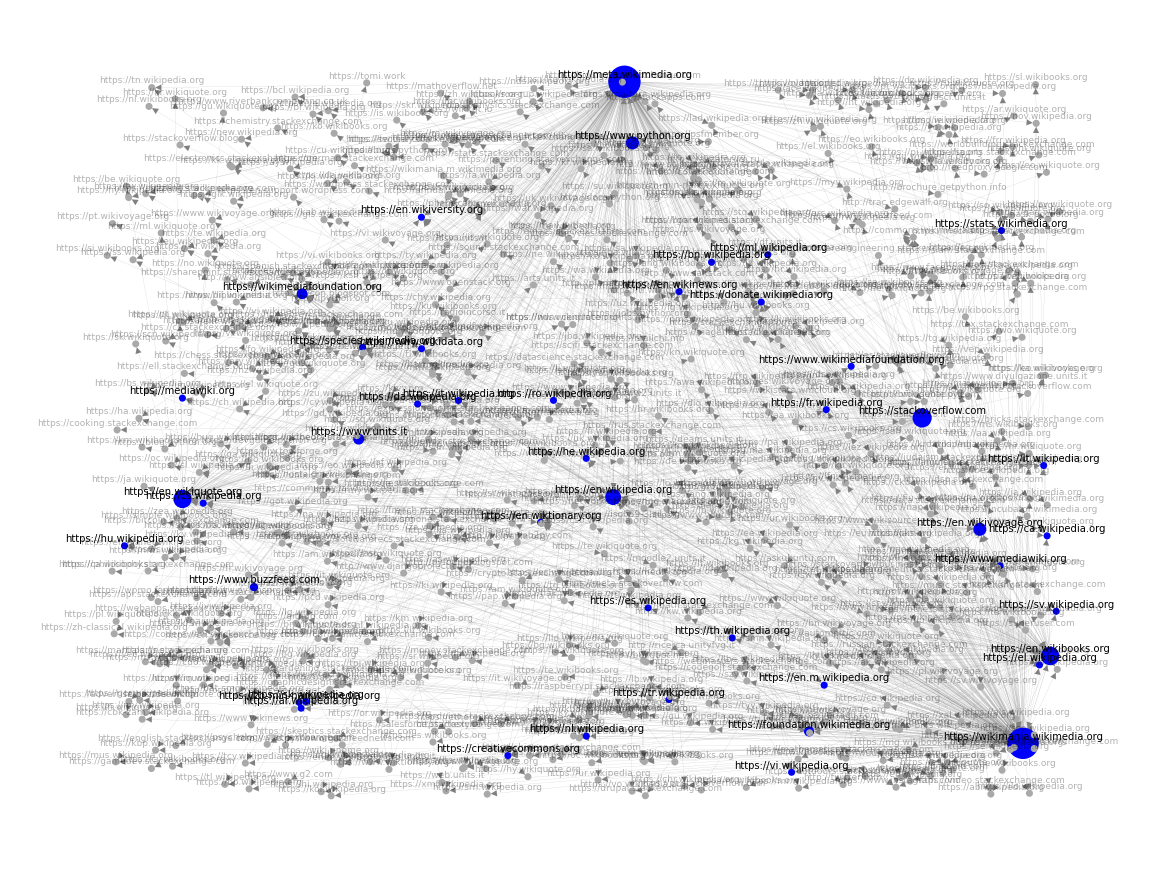

In [ ]:
# Plot network map
network_map.plot()

In [ ]:
# print frontier
url_frontier.pretty_print()

{
  "fq_size": 0,
  "pr_levels": 3,
  "bq_size": 0,
  "bq_n": 30,
  "fqs": [
    [
      "https://en.wikipedia.org/wiki/wiki/Ottoman_Navy",
      "https://en.wikipedia.org/wiki/wiki/February_16",
      "https://wikimediafoundation.org/our-work/wikimedia-projects/",
      "https://www.mediawiki.org/wiki/MediaWiki",
      "https://en.wikipedia.org/wiki/wiki/List_of_days_of_the_year",
      "https://en.wikipedia.org/wiki/wiki/Shrove_Tuesday",
      "https://en.wikipedia.org/wiki/wiki/Willa_Cather",
      "https://en.wikibooks.org/wiki/",
      "https://en.wikipedia.org/wiki/wiki/Molar_(tooth)",
      "https://en.wikipedia.org/wiki/wiki/Species_description",
      " ... 2101 more"
    ],
    [
      "https://en.wikipedia.org/wiki/wiki/Lynn_Stalmaster",
      "https://en.wiktionary.org/wiki/Wiktionary:Main_Page",
      "https://www.wikidata.org/",
      "https://fa.wikipedia.org/wiki/",
      "https://en.wikipedia.org/wiki/wiki/Director-General_of_the_World_Trade_Organization",
      "https

In [ ]:
# print network map
network_map.pretty_print()

{
  "https://www.python.org": {
    "/robots.txt": {
      "last_visit": "2021-02-16 10:44:21.141329",
      "resp_code": "200",
      "content_type": "text/plain",
      "content": "# Directions for robots.  See this URL:\n# http://www.robotstxt.org/robotstxt.html\n# for a descriptio ...",
      "out_links": []
    },
    "/": {
      "last_visit": "2021-02-16 10:46:10.689065",
      "resp_code": "200",
      "content_type": "text/html; charset=utf-8",
      "content": "<!doctype html>\n<!--[if lt IE 7]>   <html class=\"no-js ie6 lt-ie7 lt-ie8 lt-ie9\">   <![endif]-->\n<!- ...",
      "out_links": [
        "https://www.python.org/events/python-events/995/",
        "http://feedproxy.google.com/~r/PythonSoftwareFoundationNews/~3/mENgnyHf1Rs/jesse-noller-is-awarded-p ...",
        "http://www.wxpython.org/",
        "https://www.python.org/doc/",
        "http://wiki.python.org/moin/TkInter",
        "https://wiki.python.org/moin/",
        "http://www.saltstack.com/",
        "https:/

In [ ]:
# print robots cache
robots_cache.pretty_print()

{
  "https://www.python.org": {
    "Disallow": [
      "/~guido/orlijn/",
      "/webstats/"
    ],
    "Allow": []
  },
  "https://www.buzzfeed.com": {
    "Disallow": [
      "/buzz/*.xml$",
      "/category/*.xml$",
      "/mobile/",
      "*?s=bpage-next",
      "*?s=lightbox",
      "*?s=feedpager",
      "/fabordrab/",
      "/bfmp/",
      "/buzzfeed/",
      "/contest",
      " ... 15 more"
    ],
    "Allow": []
  },
  "https://en.wikipedia.org": {
    "Disallow": [
      "/w/",
      "/api/",
      "/trap/",
      "/wiki/Special:",
      "/wiki/Spezial:",
      "/wiki/Spesial:",
      "/wiki/Special%3A",
      "/wiki/Spezial%3A",
      "/wiki/Spesial%3A",
      "/wiki/%D8%AE%D8%A7%D8%B5:Search",
      " ... 411 more"
    ],
    "Allow": [
      "/w/api.php?action=mobileview&",
      "/w/load.php?",
      "/api/rest_v1/?doc"
    ]
  },
  "https://stackoverflow.com": {
    "Disallow": [],
    "Allow": []
  },
  "https://www.units.it": {
    "Disallow": [
      "/persone/",
   

## That's all folks!
Thanks for sticking around until the end!  
I hope you enjoyed reading this notebook as much as I enjoyed writing it.  
Happy crawling!  
  
### Michele Rispoli